# Customer Segmentation Analysis

In this notebook, we will perform customer segmentation based on their transactions and profile information. We will use clustering techniques, including the Elbow method and Davies-Bouldin index, to determine the optimal number of clusters. We will also evaluate the clusters using silhouette scores and visualize the results using PCA.

---

## Step 1: Importing Libraries

First, we will import the necessary libraries for data manipulation, machine learning, and visualization.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Load the Datasets

We will now load the customer and transaction datasets. These datasets contain customer and transaction details that we will use for segmentation.


In [3]:
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('Transactions.csv')
print("Customers Data:")
print(customers.head())
print("\nTransactions Data:")
print(transactions.head())


Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


## Step 3: Merging the Datasets

Now, we will merge the `customers` and `transactions` datasets based on the `CustomerID` column. This gives us a single dataframe containing both customer and transaction information.


In [4]:

data = pd.merge(transactions, customers, on='CustomerID', how='inner')
print("Merged Data:")
print(data.head())


Merged Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


## Step 4: Feature Engineering

We will now create customer profile features that we will use for segmentation. This includes calculating total spending, total items purchased, transaction frequency, and recency (days since the customer signed up).

In [8]:

print(data.columns)


customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  
    'Quantity': 'sum',    
    'TransactionID': 'count',  
    'SignupDate': 'first', 
    'Region': 'first',      
}).reset_index()

print(customer_data.columns)
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'], errors='coerce')  # Handle errors if necessary
customer_data['DaysSinceSignup'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days
customer_data.drop(columns=['SignupDate'], inplace=True)
print("Customer Data after Feature Engineering:")
print(customer_data.head())


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')
Index(['CustomerID', 'TotalValue', 'Quantity', 'TransactionID', 'SignupDate',
       'Region'],
      dtype='object')
Customer Data after Feature Engineering:
  CustomerID  TotalValue  Quantity  TransactionID         Region  \
0      C0001     3354.52        12              5  South America   
1      C0002     1862.74        10              4           Asia   
2      C0003     2725.38        14              4  South America   
3      C0004     5354.88        23              8  South America   
4      C0005     2034.24         7              3           Asia   

   DaysSinceSignup  
0              932  
1             1079  
2              326  
3              841  
4              896  


## Step 5: Data Normalization

We will normalize the data to ensure that all features are on the same scale. This is important for the clustering algorithms.


In [9]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop(columns=['CustomerID', 'Region']))
print("Scaled Customer Data:")
print(scaled_data[:5])


Scaled Customer Data:
[[-0.06170143 -0.12203296 -0.01145819  1.148752  ]
 [-0.87774353 -0.44800021 -0.46749414  1.60043068]
 [-0.40585722  0.20393428 -0.46749414 -0.71327032]
 [ 1.03254704  1.67078689  1.35664965  0.86914138]
 [-0.78392861 -0.93695108 -0.92353008  1.03813681]]


## Step 6: Determine the Optimal Number of Clusters

We will use the Elbow Method and Davies-Bouldin Index to determine the optimal number of clusters. We will evaluate different values of `k` (number of clusters) and look for the optimal `k` based on the plots and clustering metrics.


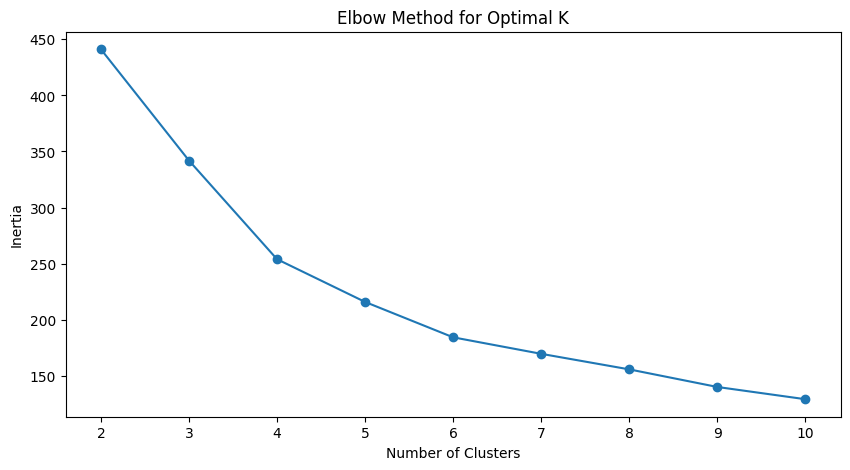

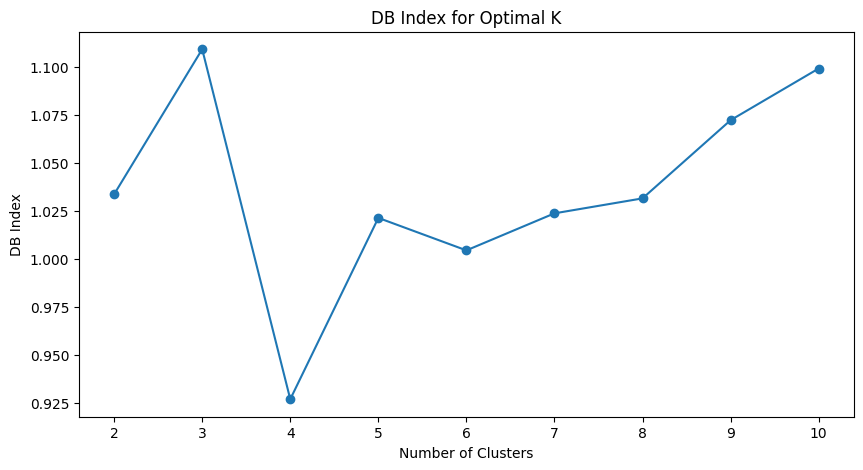

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Could not find the number of physical cores")

inertia = []
db_index = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(scaled_data, kmeans.labels_))
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db_index, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.title('DB Index for Optimal K')
plt.show()


## Step 7: Fit KMeans Clustering

Based on the plots, we will select the optimal number of clusters. Let's assume `k=4` is optimal based on the previous plots. We will then fit the KMeans model and assign the cluster labels to the customer data.


In [12]:

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

customer_data['Cluster'] = kmeans.labels_


print("Customer Data with Cluster Labels:")
print(customer_data.head())


Customer Data with Cluster Labels:
  CustomerID  TotalValue  Quantity  TransactionID         Region  \
0      C0001     3354.52        12              5  South America   
1      C0002     1862.74        10              4           Asia   
2      C0003     2725.38        14              4  South America   
3      C0004     5354.88        23              8  South America   
4      C0005     2034.24         7              3           Asia   

   DaysSinceSignup  Cluster  
0              932        1  
1             1079        1  
2              326        2  
3              841        0  
4              896        1  


## Step 8: Evaluate Clustering Performance

We will evaluate the performance of the clustering model using two metrics: the Davies-Bouldin Index and the Silhouette Score. A lower Davies-Bouldin index and a higher Silhouette score indicate better clustering.


In [13]:

db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_score}')
print(f'Silhouette Score: {silhouette_avg}')


Davies-Bouldin Index: 0.9268357619520267
Silhouette Score: 0.33531054299092644


## Step 9: Visualize Clusters Using PCA

To visualize the clusters in 2D, we will apply Principal Component Analysis (PCA) to reduce the data to two dimensions. This will allow us to plot the clusters and see their distribution.


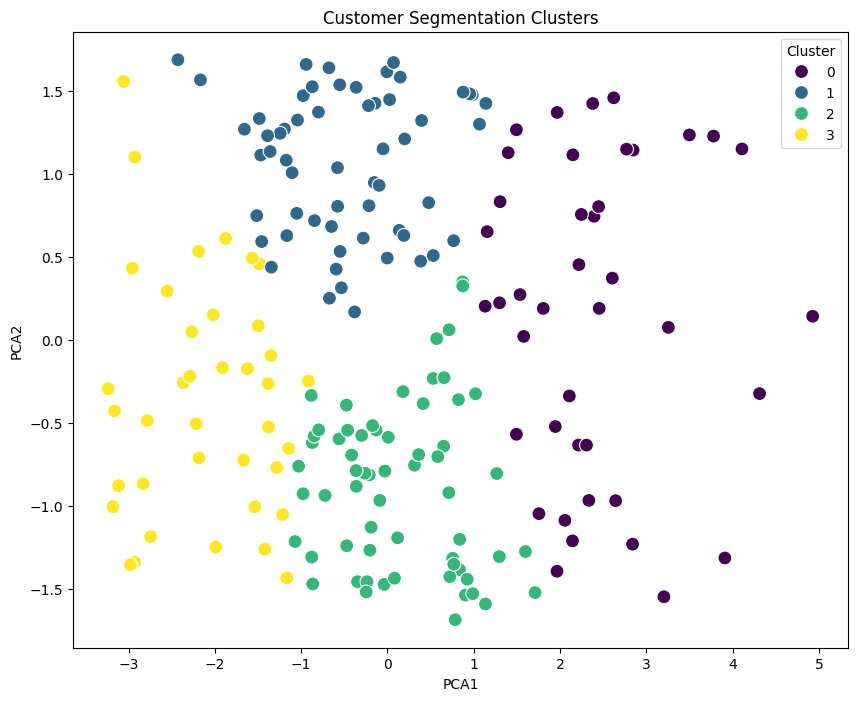

In [15]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.show()


## Step 10: Analyze Cluster Profiles

Finally, we examine the average characteristics of each cluster, such as total value, quantity, transaction frequency, and recency.


In [16]:

cluster_profiles = customer_data.groupby('Cluster').agg({
    'TotalValue': 'mean',
    'Quantity': 'mean',
    'TransactionID': 'mean',
    'DaysSinceSignup': 'mean',
    'Region': lambda x: x.mode()[0],  
}).reset_index()
print("\nCluster Profiles:")
print(cluster_profiles)



Cluster Profiles:
   Cluster   TotalValue   Quantity  TransactionID  DaysSinceSignup  \
0        0  6036.052683  21.512195       7.902439       648.121951   
1        1  2876.149483  10.724138       4.431034       895.568966   
2        2  3588.180323  13.500000       5.370968       275.048387   
3        3  1400.882895   5.157895       2.263158       407.894737   

          Region  
0  South America  
1         Europe  
2  North America  
3           Asia  
